<a href="https://colab.research.google.com/github/CarlosTadeuVassoler/IA/blob/main/Modelo_de_IA_para_classifica%C3%A7%C3%A3o_de_imagens_entre_5_classes_de_alimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de inteligência artificial para classificação de imagem entre 5 classes de alimentos

Neste projeto, treinou-se uma rede neural baseada na arquitetura VGG com o objetivo de disinguir imagens de alimentos entre 5 classes:
- churros;
- donuts;
- hamburguer;
- pizza;
- sushi.

Para isto, utilizou-se como base a arquitetura VGG, um modelo de rede neural convulacional, além da base de dados Food101. Mais informações estão disponíveis em:

- CNN VGG: https://poloclub.github.io/cnn-explainer/
- Food101: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

## Importanto bibliotecas

No desenvolvimento do projeto, diversas bibliotecas foram utilizadas tanto para a criação do modelo de inteligência artificial, quanto para manusear arquivos e auxiliar a programação.

A importação de todas elas pode ser vista abaixo, bem como uma breve explicação de sua utilidade:

In [ ]:
import torch #biblioteca para lidar com tensors, a representação dos dados utilizada pela rede neural
from torch import nn #classe com os modelos base pre-desenvolvidos
from torchvision import datasets, transforms #guardar a coleção de dados, além de transforma-los, se necessário
from torch.utils.data import DataLoader #organizar conjunto de dados em lotes (batches) para treinamento de modelos
!pip install torchinfo;
from torchinfo import summary #fornece um resumo detalhado de cada camada do modelo criado
!pip install torchmetrics -U mlxtend;
import torchmetrics, mlxtend #criação da matriz confusão
from torchmetrics import ConfusionMatrix #criação da matriz confusão
from mlxtend.plotting import plot_confusion_matrix #criação da matriz confusão

import os #interação com o sistema operacional, como leitura de arquivos e contagem de nucleos de processamento
from pathlib import Path #representar o caminho para um arquivo
import shutil #copiar/criar arquivos
import requests #fazer solicitações de HTTP (links)
import zipfile #criação de arquivos compactados
import csv #salvar/carregar as curvas de loss/accuracy

import random #utilizada para obter números ou sequências aleatórias

import numpy as np #estrutura de dados eficientes para matrizes multidimensionais
from tqdm.auto import tqdm #visualização de uma barra de progresso em loops (ex: for i in tqdm(range(2)):)

import matplotlib.pyplot as plt #plotar gráficos e imagens
from PIL import Image #abrir imagens a partir de arquivos salvos

## Configurando o código independente do dispositivo (device-agnostic code)

Em casos onde se tem uma grande quantidade de dados, é comum que os modelos de inteligência artificial levem um tempo elevado para serem treinados. Utilizar uma GPU é uma forma de contornar este problema, visto que a quantidade de memória disponível para processamento pode ser maior que a utilizada pelo CPU.

Porém, há casos onde não se tem uma GPU disponível. Desta forma, é uma boa prática escrever códigos que independem do dispositivo disponível. Foi estabelecida então uma condição que utiliza como dispositivo uma GPU fornecida pelo Colab, se a mesma estiver disponível, caso contrário, utiliza-se o próprio CPU.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Adquirindo dados

A biblioteca torchinfo fornece bases de dados preestabelecidas, como o caso do Food101. Neste dataset, têm-se 101 classes de alimentos com 1000 imagens cada.

A variedade de classes disponíveis é muito grande, de modo que seria necessário um modelo complexo ou então muito tempo de treinamento para se atingir resultados satisfatórios na classificação das mesmas. Isto foge dos objetivos deste projeto, logo, foram selecionados os dados das 5 classes mencionadas anteriormente.

Para isto, foram seguidos os seguintes passos:

- Todas as imagens foram baixadas, utilizando a função `baixar_todas_as_imagens`;
- Selecionou-se as classes desejadas entre todas as imagens baixadas, separando 80% das imagens para treino do modelo e 20% para teste. A função utilizada nesse passo foi `selecionar_classes`.

Criou-se também um arquivo .zip para que o download dos arquivos levasse menos tempo em outras execuções do notebook. O mesmo foi enviado para um diretório no github, e importado utilizando a função `baixar_do_git`.

Todas estas funções estão definidas abaixo:

In [3]:
def baixar_todas_as_imagens(data_path):
  imagens_treino = datasets.Food101(root=data_path,
                                    split="train",
                                    transform=transforms.ToTensor(),
                                    download=True)
  
  imagens_teste = datasets.Food101(root=data_path,
                                   split="test",
                                   transform=transforms.ToTensor(),
                                   download=True)
  
  nomes_classes = imagens_treino.classes

  return imagens_treino, imagens_teste, nomes_classes

In [4]:
def selecionar_classes(data_path,
                       classes,
                       train_size=0.8):
  images_path = data_path / "food-101/images"
  label_path = data_path / "food-101/meta"

  treino_teste = ["train.txt", "test.txt"]
  
  lista_paths = []

  for pasta in treino_teste:
    with open(label_path / pasta, "r") as f:
      lista_labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in classes]

    lista_paths += [Path(str(images_path / label) + ".jpg") for label in lista_labels]

  path_pasta = data_path / "classes_selecionadas"
  path_pasta.mkdir(parents=True, exist_ok=True)

  tamanho_treino = int(train_size * len(lista_paths))

  lista_paths_treino = random.sample(lista_paths, tamanho_treino)
  lista_paths_teste = [path for path in lista_paths if path not in lista_paths_treino]

  for image_path in lista_paths_treino + lista_paths_teste:
    if image_path in lista_paths_treino:
      destino = path_pasta / "treino" / image_path.parent.stem / image_path.name
    else:
      destino = path_pasta / "teste" / image_path.parent.stem / image_path.name
    if not destino.parent.is_dir():
      destino.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src=image_path, dst=destino)

  shutil.make_archive(str(path_pasta),
                      format="zip",
                      root_dir=path_pasta);

In [5]:
def baixar_do_git(data_path):
  image_path = data_path / "classes_selecionadas"

  if not image_path.is_dir():
    image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "classes_selecionadas.zip", "wb") as f:
    request = requests.get("https://github.com/CarlosTadeuVassoler/IA/raw/main/data/classes_selecionadas.zip")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "classes_selecionadas.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

Uma vez definidas, estas funções podem ser utilizadas dependendo do caso atual:

- Se for desejado baixar classes específicas, utilizar a opção 1;
- Se for desejado utilizar as classes baixadas anteriormente, utilizar a opção 2.

In [6]:
data_path = Path("data/")

#opção 1: baixar todas as imagens do Food101
#opção 2: baixar as que ja selecionou anteriormente

OPCAO = 2
classes_desejadas = ["pizza", "sushi", "hamburger", "donuts", "churros"]

if OPCAO == 1:
  train_data, test_data, class_names = baixar_todas_as_imagens(data_path)
  selecionar_classes(data_path, classes_desejadas)
else:
  baixar_do_git(data_path)

## Adquirindo familiaridade com os dados

### Quantidade de imagens
Agora que os dados foram selecionados, foi necessário saber com o que se estava lidando. O primeiro passo foi verificar quantos dados temos para cada passo do desenvolvimento do modelo. Para isto, utilizou-se a função `quantidade_de_imagens`, definida abaixo: 

In [7]:
def quantidade_de_imagens(image_path):
  index = []
  print("A quantidade de imagens disponível é:")
  for path, nome_pasta, nome_arquivos in os.walk(image_path):
    if len(nome_arquivos) > 0:
      print(f" {len(nome_arquivos)} imagens de {path.split('/')[-1]}")
      if len(index) > 0:
        index.append(len(nome_arquivos) + index[-1])
      else:
        index.append(len(nome_arquivos)-1)
    elif path.split('/')[-1] == "treino":
      print()
      print("-Para treinamento do modelo:")
    elif path.split('/')[-1] == "teste":
      print()
      print("-Para teste do modelo:")

  return index

index_primeiras = quantidade_de_imagens(data_path / "classes_selecionadas")

A quantidade de imagens disponível é:

-Para treinamento do modelo:
 801 imagens de sushi
 810 imagens de churros
 784 imagens de hamburger
 815 imagens de pizza
 790 imagens de donuts

-Para teste do modelo:
 199 imagens de sushi
 190 imagens de churros
 216 imagens de hamburger
 185 imagens de pizza
 210 imagens de donuts


Além de conhecer a quantidade de imagens disponível, foi interessante visualizar exemplos desses dados. Com este objetivo, foi definida a função `mostrar_imagens`, que também terá usos futuros.

In [8]:
def mostrar_imagens(image_path,
                    sub_plot=[],
                    transform=None):
  if len(sub_plot) == 0:
    plt.figure(figsize=(5, 5))
    img = Image.open(image_path)
    img_array = np.asarray(img)
    plt.imshow(img_array)
    plt.title(str(image_path.parent.stem).capitalize())
    plt.axis(False);
  else:
    linhas, colunas = sub_plot[0], sub_plot[1]
    for i, path in enumerate(image_path):
      plt.subplot(linhas, colunas, i+1)
      img = Image.open(path)
      if transform is not None and i % 2 != 0:
        img = transform(img).permute(1, 2, 0)
      img_array = np.asarray(img)
      plt.imshow(img_array)
      plt.title(str(path.parent.stem).capitalize())
      plt.axis(False);

### Visualizando um exemplo de cada classe de imagem

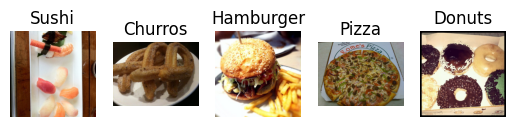

In [9]:
images_path = data_path / "classes_selecionadas/treino"
lista_paths_imagens = list(images_path.glob("*/*.jpg"))
uma_de_cada = [lista_paths_imagens[i-8] for i in index_primeiras[:len(classes_desejadas)]]

mostrar_imagens(uma_de_cada, sub_plot=[1, len(classes_desejadas)])

Nota-se que as imagens têm diferentes dimensoes, orientações e qualidades. Além disso, algumas delas possuem ruídos que dificultam a performance do modelo, como no caso da xícara na imagem dos churros, ou a batata frita na imagem do Hamburguer, que causaria confusão caso "batata frita" fosse uma classe a qual se desejasse classificar.

### Aumentando a diversidade de imagens

Para melhorar a capacidade de generalização do modelo, foi utilizada a técnica de "Data Augmentation". Nesta, aplicam-se transformações simples e básicas aos dados existentes para criar novas variações, ajudando a melhorar a robustez do modelo.

Além disso, as imagens devem ser redimensionadas, para que a entrada do modelo, bem como as suas dimensões de saída sejam constantes.

Foram definidas abaixo tais transformações:

In [10]:
TAMANHO_IMAGEM = 64

transform_treino = transforms.Compose([
    transforms.Resize(size=(TAMANHO_IMAGEM, TAMANHO_IMAGEM)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

transform_teste = transforms.Compose([
    transforms.Resize(size=(TAMANHO_IMAGEM, TAMANHO_IMAGEM)),
    transforms.ToTensor()
])

### Visualizando imagens transformadas

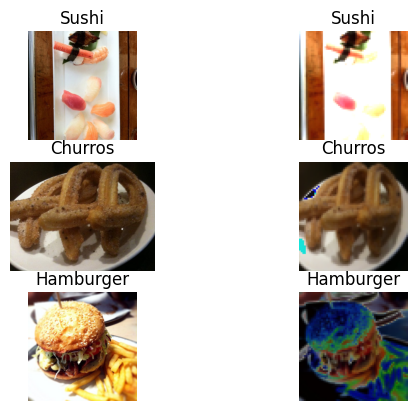

In [11]:
torch.manual_seed(4022002)

imagens_transformadas = []
for path in uma_de_cada[:3]:
  imagens_transformadas.append(path)
  imagens_transformadas.append(path)

mostrar_imagens(imagens_transformadas, sub_plot=[int(len(imagens_transformadas)/2), 2], transform=transform_treino)

Neste caso, as alterações mais expressivas são em relação a coloração e qualidade da imagem, que se perdeu devido ao redimensionamento, facilitando talvez o aprendizado da rede neural.

Além destas, durante a augmentation, é comum que as imagens sejam rotacionadas, transladadas, cortadas, invertidas, entre outros. Mais informações em:
- https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

## Criando o dataset

Uma vez que os dados são conhecidos, carregou-se as imagens em formato de dataset, utilizando a classe `ImageFolder`. Esta faz uma varredura em um caminho indicado, transformando as imagens em tensors, além de armazenar suas classificações reais, baseadas na pasta em que as imagens se encontram. Tais classificações são utilizadas para validar os resultados obtidos pelo modelo durante o treinamento e teste do mesmo.

A definição dos datasets, bem como alguns atributos dos mesmos, podem ser vistas como segue:

In [45]:
path_treino = data_path / "classes_selecionadas/treino"
path_teste = data_path / "classes_selecionadas/teste"

train_data = datasets.ImageFolder(root=path_treino,
                                  transform=transform_treino)

test_data = datasets.ImageFolder(root=path_teste,
                                  transform=transform_teste)

class_names = train_data.classes
print(f"Classes: {class_names}")
print(f"Identificação das mesmas: {train_data.class_to_idx}\n")
print("Identificação aplicada na lista de imagens:")
print([0, 0, 0, "...", 1, 1, 1, "...", 2, 2, 2, "...", 3, 3, 3, "...", 4, 4, 4, "..."])

Classes: ['churros', 'donuts', 'hamburger', 'pizza', 'sushi']
Identificação das mesmas: {'churros': 0, 'donuts': 1, 'hamburger': 2, 'pizza': 3, 'sushi': 4}

Identificação aplicada na lista de imagens:
[0, 0, 0, '...', 1, 1, 1, '...', 2, 2, 2, '...', 3, 3, 3, '...', 4, 4, 4, '...']


## Criando o dataloader

Uma vez estabelecido o dataset, separou-se o mesmo em lotes (batches) utilizando a classe `DataLoader`. Isto se faz para que o dispositivo de processamento de dados consiga lidar com grandes quantidades de imagens, além de favorecer o aprendizado do modelo.

Neste projeto, tem-se 4000 imagens destinadas para treinamento do modelo. Se tentassemos fazer um laço de aprendizado com essas 4000 imagens em toda iteração, pode ser que a memória da GPU/CPU não fosse suficiente para armazena-las. Além disso, os parâmetros do modelo só seriam atualizados uma vez a cada 4000 imagens processadas.

Alternativamente, o conjunto de imagens foi dividido em lotes de 32 imagens. Desta forma, em cada iteração do aprendizado, os parâmetros do modelo são atualizados 125 vezes, impulsionando os resultados. Além disso, garante-se que a memória do dispositivo será suficiente.

Por fim, é interessante destacar que os dados de treinamento foram embaralhados, para que o modelo não aprendesse a detectar a sequência das imagens, mas sim seus padrões/características. Já os dados de teste foram mantidos com sua ordem original, para que fossem mais fáceis de ser analisados.

In [13]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

## Criação do modelo

Antes de criar o modelo em si, foi necessário conhecer o formato de entrada do mesmo.

Sabe-se que as imagens foram redimensionadas para 64x64. Além disso, quando se utilizam tensors para representa-las, divide-se a imagens em 3 canais de cores: vermelho; verde; azul. Desta forma, cada imagem é dividida em 3 outras, as quais possuem cada um de seus píxels representados por uma intensidade da cor primária. Uma vez mescladas, obtém-se a imagem original.

Por fim, além das dimensões `color channels`, `height` e `width`, temos a dimensão dos `batches` (lotes), como mostrado abaixo:

In [14]:
batch_images, batch_labels = next(iter(train_dataloader))
batch_images.shape

torch.Size([32, 3, 64, 64])

Foi criada uma classe para o modelo, a qual recebe como parâmetros o formato de entrada das imagens (`input_shape`), a quantidade de neurônios pode camada (`unidades_por_camada`) e a quantidade de resultados possíveis (`output_shape`).

Com esses dados, foram construídas as camadas da rede neural, denominadas por `self.bloco`. Cada uma destas possui as seguintes operações:

- Convluação bidimensional (`Conv2d`): utilizada para extrair características das imagens realizando multiplicações entre uma matriz de pesos e as matrizes representando a imagem;
- Rectified Linear Unit (`ReLU`): função de ativação que introduz não linearidade no modelo. Dado um input x, retorna o valor max(0, x);
- Max Pooling Bidimensional (`MaxPool2d`): utilizada para reduzir a resolução das imagens, mantendo as características mais proeminentes.

Em cada camada, como consta na arquitetura VGG, foi utilizada a sequência: `Conv2d` -> `ReLU` -> `Conv2d` -> `ReLU` -> `MaxPool2d`. Foram estabelecidas, portanto, 3 camadas seguindo essa sequência.

O resultado destas manipulações é enviado para uma camada de classificação, que possui as operações:

- `Flatten`: utilizada para transformar uma matriz multidimensional em um vetor unidimensional;
- `Linear`: utilizada para direcionar o vetor unidimensional gerado anteriormente para cada uma das classes as quais o modelo esta sendo treinado.

A primeira operação do primeiro bloco recebe como `in_channels` o valor do input_shape. As operações anteriores à camada de classificação recebem como `in_channels` e `out_channels` a quantidade de neurônios. Por fim, a operação linear na camada de classificação recebe como `in_channels` a multiplicação entre a quantidade de neurônios e as dimensões finais da imagem na camada anterior (valor obtido com a geração de um resumo detalhado das camadas do modelo, mostrado posteriormente) e como `out_channels` a quantidade de classes a serem classificadas.

In [17]:
class Modelo(nn.Module):
  def __init__(self, input_shape, unidades_por_camada, output_shape):
    super().__init__()
    self.bloco1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=unidades_por_camada,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=unidades_por_camada,
                  out_channels=unidades_por_camada,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.bloco2 = nn.Sequential(
        nn.Conv2d(in_channels=unidades_por_camada,
                  out_channels=unidades_por_camada,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=unidades_por_camada,
                  out_channels=unidades_por_camada,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.bloco3 = nn.Sequential(
        nn.Conv2d(in_channels=unidades_por_camada,
                  out_channels=unidades_por_camada,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=unidades_por_camada,
                  out_channels=unidades_por_camada,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classificador = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=unidades_por_camada*8*8,
                  out_features=output_shape)
    )
  
  def forward(self, x):
    return self.classificador(self.bloco3(self.bloco2(self.bloco1(x))))

A seguir, foi criado um objeto `modelo` para ser treinado, bem como um resumo detalhado de cada uma de suas camadas:

In [18]:
modelo = Modelo(input_shape=3,
                unidades_por_camada=30,
                output_shape=len(train_data.classes)).to(device)

summary(modelo, input_size=[1, 3, TAMANHO_IMAGEM, TAMANHO_IMAGEM])

Layer (type:depth-idx)                   Output Shape              Param #
Modelo                                   [1, 5]                    --
├─Sequential: 1-1                        [1, 30, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 30, 64, 64]           840
│    └─ReLU: 2-2                         [1, 30, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 30, 64, 64]           8,130
│    └─ReLU: 2-4                         [1, 30, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 30, 32, 32]           --
├─Sequential: 1-2                        [1, 30, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 30, 32, 32]           8,130
│    └─ReLU: 2-7                         [1, 30, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 30, 32, 32]           8,130
│    └─ReLU: 2-9                         [1, 30, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 30, 16, 16]           --
├─Seq

Uma vez analisado o resumo, vemos que a saída do bloco anterior à camada de classificação é [1, 30, 8, 8]. Desta forma, a entrada da camada de classificação deve ser a multiplicação entre estes termos, como foi colocado na classe do modelo.

## Funções de treinamento e teste

Foram definidas funções para treinamento e teste do modelo.

A função de `treinamento` recebe como parâmetros:

- Modelo a ser treinado;
- Conjunto de dados de treinamento;
- Função de perda (Loss);
- Otimizador;
- Número de épocas de treinamento.

Com estes dados, faz-se um laço pelo número de épocas, e outro por cada um dos lotes de dados, aplicando os passos de treinamento, descritos no próprio código, e armazenando dados de Loss e Accuracy para avaliação do modelo.

Já a função `teste` recebe os mesmos parâmetros, exceto o número de épocas e o otimizador, que não são necessários. O procedimento para teste do modelo foi descrito no próprio código.

In [19]:
def treinamento(modelo,
                dataloader,
                loss_fun,
                otimizador,
                epochs):
  
  train_loss, train_acc = [], []

  #coloca-se o modelo em modo de treino, rastreando os gradientes
  modelo.train()

  #loop pelo número de épocas
  for _ in tqdm(range(epochs)):
    train_loss.append(0)
    train_acc.append(0)

    #loop por cada lote de dados
    for batch, (X, y) in enumerate(dataloader):
      #os dados são passados para o dispositivo disponível
      X, y = X.to(device), y.to(device)

      #os dados de entrada são passados pelas camadas do modelo, gerando a saída bruta do mesmo (logits)
      y_logits = modelo(X)

      #calcula-se o quão errado foi a previsão do modelo
      loss = loss_fun(y_logits, y)

      #zerar os gradientes da iteração anterior
      otimizador.zero_grad()

      #calcula-se os gradientes dos parâmetros do modelo em relação a função perda
      loss.backward()

      #atualiza-se os parâmetros do modelo com base nos gradientes gerados
      otimizador.step()

      #armazena-se os dados de loss e accuracy gerados
      train_loss[_] += loss.item()
      train_acc[_] += (torch.argmax(torch.softmax(y_logits, dim=1), dim=1) == y).sum().item() / len(y_logits)

    train_loss[_] /= len(dataloader)
    train_acc[_] /= len(dataloader)
    print(f"EPOCH {_+1} => Loss: {train_loss[_]:.4f} | Accuracy: {train_acc[_]:.4f}")

  return train_loss, train_acc

In [36]:
def teste(modelo,
          dataloader,
          loss_fun):
  
  loss_teste, accuracy_teste = 0, 0
  
  #coloca-se o modelo em modo de avaliação, desativando o rastreamento de gradientes
  modelo.eval()

  #sem rastrear os gradientes
  with torch.inference_mode():

    #loops por cada lote de dados
    for batch, (X, y) in enumerate(dataloader):
      #os dados são passados para o dispositivo disponível
      X, y = X.to(device), y.to(device)

      #os dados de entrada são passados pelas camadas do modelo, gerando a saída bruta do mesmo (logits)
      y_logits = modelo(X)

      #calcula-se o quão errado foi a previsão do modelo e armazena este valor
      loss = loss_fun(y_logits, y)
      loss_teste += loss.item()

      #transforma-se a previsão bruta em probabilidades
      y_prob = torch.softmax(y_logits, dim=1)

      #obtem-se a maior probabilidade
      y_pred = y_prob.argmax(dim=1)

      #compara cada previsão com o valor real, obtendo a porcentagem de previsões corretas
      accuracy_teste += ((y_pred == y).sum().item()/len(y_pred))

  print(f"Loss: {(loss_teste / len(dataloader)):.4f} | Accuracy: {(accuracy_teste / len(dataloader)):.4f}")

## Funções para salvar e carregar modelos já treinados anteriormente

Devido ao tempo que se leva para treinar o modelo, é comum salvar o mesmo após o treinamento. Além disso, para usos posteriores, é de grande interesse carregar o modelo que foi salvo anteriormente. Para isto, definiu-se as funções `salvar_modelo` e `carregar_modelo`.

In [21]:
def salvar_modelo(nome, modelo):
  MODEL_PATH = Path("models")
  MODEL_PATH.mkdir(parents=True, exist_ok=True)

  MODEL_NAME = nome
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
  torch.save(obj=modelo.state_dict(), f=MODEL_SAVE_PATH)

In [22]:
def carregar_modelo(data_path, modelo, nome):
  model_path = data_path / "models"

  if not model_path.is_dir():
    model_path.mkdir(parents=True, exist_ok=True)

  with open(model_path / nome, "wb") as f:
    request = requests.get("https://github.com/CarlosTadeuVassoler/IA/raw/main/data/" + nome)
    f.write(request.content)

  modelo.load_state_dict(torch.load(f=model_path / nome, map_location=torch.device(device)))

## Funções para salvar e baixar as curvas de Loss e Accuracy

Os dados para as curvas de Loss e Accuracy só são gerados caso o modelo seja treinado na execução do notebook. Com o objetivo de expô-las ao leitor, uma vez que utiliza-se o carregamento do modelo já treinado previamente na execução do notebook, definiram-se funções para salvar as curvas geradas durante algum treino, bem como carregar alguma curva gerada anteriormente. São as funções `salvar_curvas` e `baixar_curvas`.

In [23]:
def salvar_curvas(data_path, nome, dados):
  path_csv = data_path / nome

  dados = zip(dados[0], dados[1])

  with open(path_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(dados)

In [24]:
def baixar_curvas(data_path, nome):
  with open(data_path / nome, "wb") as f:
    request = requests.get("https://github.com/CarlosTadeuVassoler/IA/raw/main/data/" + nome)
    f.write(request.content)

  train_loss, train_acc = [], []

  with open(data_path / nome, "r") as f:
    leitor = csv.reader(f)

    for linha in leitor:
      loss, acc = linha
      train_loss.append(float(loss))
      train_acc.append(float(acc))

  return train_loss, train_acc

## Treinando o modelo

Para treinar o modelo, basta chamar as funções definidas anteriormente, uma vez selecionados a função de perda e o otimizador. Neste projeto, utilizou-se a função de perda `CossEntropyLoss`, visto que se tinha uma classificação multiclasses. Já como otimizador, foi utilizado o `Adam` com taxa de aprendizado de 0.001.

É possível visualizar abaixo como as funções `treinamento`, `salvar_modelo` e `salvar_curvas` devem ser utilizadas. Além disso, foi demonstrado também como `carregar_modelo` e `baixar_curvas`, como é o caso desta execução.

In [29]:
loss_fun = nn.CrossEntropyLoss()
otimizador = torch.optim.Adam(params=modelo.parameters(), lr=0.001)

TREINAR = False

if TREINAR:
  EPOCHS = 100
  train_loss, train_acc = treinamento(modelo, train_dataloader, loss_fun, otimizador, EPOCHS)
  salvar_modelo(f"{EPOCHS}_EPOCHS_de_treino.pth")
  salvar_curvas(data_path, "curvas.csv", [train_loss, train_acc])
else:
  carregar_modelo(data_path, modelo, "250_epochs_de_treino.pth")
  train_loss, train_acc = baixar_curvas(data_path, "curvas.csv")

## Avaliando o modelo

Diversas são as formas de avaliar um modelo treinado anteriormente. Neste projeto, foram utilizados os seguintes métodos:

- Teste com os dados que não foram utilizados para treinamento;
- Curvas de Perda (Loss) e Precisão (Accuracy);
- Matriz Confusão.

### Resultados do teste

20% dos dados baixados do Food101 foram selecionados para teste. Abaixo, pode ser vista a função `teste` sendo chamada com estes dados, bem como os resultados gerados.

In [37]:
teste(modelo, test_dataloader, loss_fun)

Loss: 0.2985 | Accuracy: 0.9199


### Curvas de Loss e Accuracy

Para plotar as curvas de Perda e Precisão, foi definida a função `plotar_curvas`, que recebe tais dados.

In [31]:
def plotar_curvas(epochs_num,
                  loss_data,
                  acc_data):
  epochs = [i+1 for i in range(epochs_num)]
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss_data, label="train_loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc_data, label="train_accuracy")
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")

Se o modelo foi treinado na execução deste notebook, plota-se a curva obtida. Por outro lado, se o modelo foi carregado, utilizam-se as curvas representativas para a visualização do leitor.

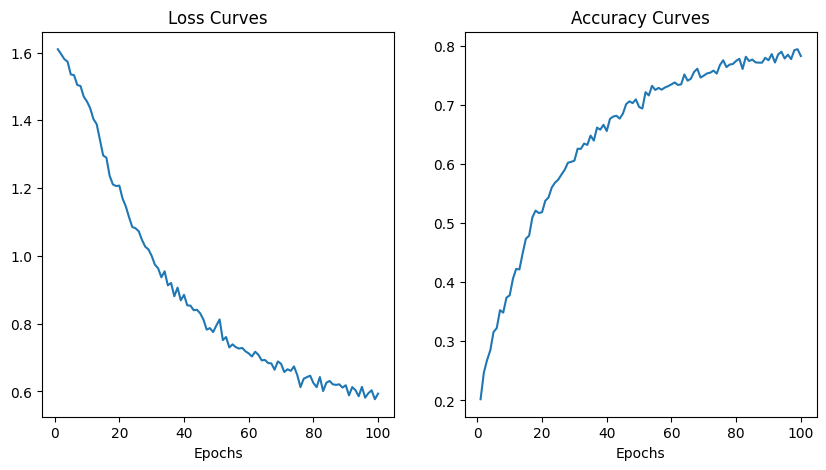

In [32]:
plotar_curvas(len(train_loss), train_loss, train_acc)

### Matriz Confusão

Por fim, foi criada uma matriz de confusão, também conhecida como tabela de contingência. Para isto, armazenou-se os resultados do modelo uma vez que os dados de teste são passados pelo mesmo, como mostrado abaixo:

In [33]:
y_preds = []
modelo.eval()
with torch.inference_mode():
  for (X, y) in (test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = modelo(X)
    y_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_probs, dim=1)
    y_preds.append(y_pred)

y_preds = torch.cat(y_preds)

Os valores esperados da saída do modelo são obtidos utilizandos `test_data.targets`. Estes são comparados com as previsões geradas, e a matriz confusão plotada, como mostrado abaixo:

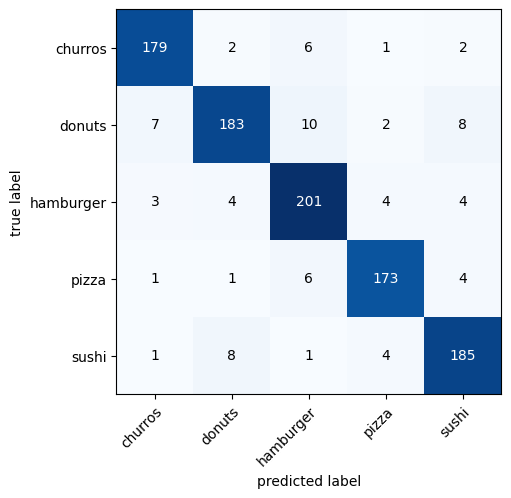

In [35]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to("cpu")
confmat_tensor = confmat(preds=y_preds.to("cpu"),
                         target=torch.tensor(test_data.targets).to("cpu"))

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(5, 5)
)

## Analisando os resultados

Os `resultados do teste` mostram que o modelo carregado é eficaz, visto que foi obtida uma precisão próxima de 92% com os dados não utilizados para o treinamento. Não é possível verificar se está havendo underfitting ou overfitting entre os dados de treinamento e teste, uma vez que as curvas não foram salvas. Porém, como `curva de Accuracy` parece estar se estabilizando (para um valor acima de 80%) após 100 iterações de treino, acredita-se que após as 250 iterações em que o modelo carregado foi treinado, o valor atingido foi bem próximo dos 92%. Conclui-se que as curvas de teste e treino foram similares.

Já na `matriz confusão`, observa-se uma grande densidade de previsões corretas na diagonal principal, o que é um ponto positivo, visto que isso mostra que em grande parte das imagens, as previsões do modelo foram corretas. As piores previsões foram obtidas para a classe `donuts`, demonstrando que a qualidade/diversidade ou a quantidade de ruídos não favoreceu o treinamento do modelo. Ainda assim, os resultados são satisfatórios.

Com base no que foi discutido, conclui-se que o treinamento de uma rede neural seguindo a arquitetura VGG e utilizando os dados da base Food101 foi satisfatório, uma vez que se atingiu alta precisão nas previsões. Acredita-se que a quantidade de épocas para treinamento foi suficientemente alto, uma vez que as curvas atingiram valores constantes. Para melhoras os resultados, sugere-se a utilização de mais dados para treinamento, ou que se diversifique mais os mesmos. Utilizar os dados sem Augmentation após este treinamento prévio pode melhorar os resultados para a base de dados utilizados, uma vez que dobraria a quantiade de imagens que o modelo utiliza para treinar. Além disso, poderiam-se ser testados outros HIPERPARÂMETROS, como o número de neurônios, o tamanho das imagens, a taxa de aprendizado, entre outros.